#**GPW 2 - Deep Learning - group 10716**

#Step 1 - Downloading data and exploratory data analysis
* S&P500 - "SPY"
* 20 years Treasury Bond ETF - "TLT"
* Cash-like - 1-3 year Treasury Bond ETF - "SHY"
* Gold - "GLD"
* Crude Oil - "DBO"

In [67]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss


In [68]:
#Download data from yahoo finance
tickers = ["SPY", "TLT", "SHY", "GLD", "DBO"]
df = yf.download(tickers, start="2018-01-01", end="2022-12-30")
display(df.head())

/tmp/ipython-input-2706298691.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2018-01-01", end="2022-12-30")
[*********************100%***********************]  5 of 5 completed


Price          Close                                                     High  \
Ticker           DBO         GLD        SHY         SPY         TLT       DBO   
Date                                                                            
2018-01-02  8.944057  125.150002  71.762192  238.568771  102.432419  8.970389   
2018-01-03  9.137156  124.820000  71.762192  240.077728  102.922188  9.137156   
2018-01-04  9.154711  125.459999  71.727898  241.089600  102.905869  9.181042   
2018-01-05  9.110826  125.330002  71.727898  242.696198  102.611992  9.128380   
2018-01-08  9.163488  125.309998  71.727898  243.140060  102.546715  9.172266   

Price                                                      ...      Open  \
Ticker             GLD        SHY         SPY         TLT  ...       DBO   
Date                                                       ...             
2018-01-02  125.180000  71.787875  238.604284  103.265007  ...  8.952834   
2018-01-03  125.089996  71.779312  240.228638  103.011977  ...  9.014275   
2018-01-04  125.849998  71.745024  241.577813  102.979335  ...  9.137156   
2018-01-05  125.480003  71.736461  242.820452  102.995635  ...  9.084494   
2018-01-08  125.320000  71.745024  243.299828  102.873220  ...  9.119603   

Price                                                      Volume            \
Ticker             GLD        SHY         SPY         TLT     DBO       GLD   
Date                                                                          
2018-01-02  124.660004  71.787875  237.743280  103.248678  155000  11762500   
2018-01-03  125.050003  71.753628  238.737396  102.848727  216000   7904300   
2018-01-04  124.889999  71.719334  240.725695  102.563041  184600   7329700   
2018-01-05  124.930000  71.719334  241.888450  102.742596  307700   5739900   
2018-01-08  125.199997  71.745024  242.598591  102.840569  183400   3566700   

Price                                    
Ticker          SHY       SPY       TLT  
Date                                     
2018-01-02  1786000  86655700  16238200  
2018-01-03  1040900  90070400   8605100  
2018-01-04   955400  80636400   9217900  
2018-01-05   850600  83524000  10915400  
2018-01-08   597700  57319200   8850600  

[5 rows x 25 columns]

In [69]:
#Download data into CSV file in case yf finance API reaches its capacity
df.to_csv("etf_data.csv")

In [70]:

#open file
df = pd.read_csv("etf_data.csv")


In [71]:
df.columns

Index(['Price', 'Close', 'Close.1', 'Close.2', 'Close.3', 'Close.4', 'High',
       'High.1', 'High.2', 'High.3', 'High.4', 'Low', 'Low.1', 'Low.2',
       'Low.3', 'Low.4', 'Open', 'Open.1', 'Open.2', 'Open.3', 'Open.4',
       'Volume', 'Volume.1', 'Volume.2', 'Volume.3', 'Volume.4'],
      dtype='object')

In [72]:
#Adjust data

df = pd.read_csv("etf_data.csv", header=[0, 1], index_col=0)
df.columns = [f"{col[0]} {col[1]}" if col[1] else col[0] for col in df.columns]
df.index.name = "Date"

In [73]:
#Rename close columns for better interpretability

df = df.rename(columns={
    "Close SPY": "SP500",
    "Close TLT": "20Treasu",
    "Close GLD": "Gold",
    "Close DBO": "Oil",
    "Close SHY": "Cash",
})

# keep only close columns
df = df.iloc[:, :5]
df

,Oil,Gold,Cash,SP500,20Treasu
Date,,,,,
2018-01-02,8.944057,125.150002,71.762192,238.568771,102.432419
2018-01-03,9.137156,124.820000,71.762192,240.077728,102.922188
2018-01-04,9.154711,125.459999,71.727898,241.089600,102.905869
2018-01-05,9.110826,125.330002,71.727898,242.696198,102.611992
2018-01-08,9.163488,125.309998,71.727898,243.140060,102.546715
...,...,...,...,...,...
2022-12-22,13.364376,166.759995,74.214691,368.071991,93.848289
2022-12-23,13.693008,167.259995,74.178177,370.189240,92.472404
2022-12-27,13.793423,168.669998,74.077858,368.729370,90.643959


##**Exploratory data analysis**

* This project will focus on predicting 25 days ahead cumulative returns using past price from its own series.


In [74]:
# Compute log returns
returns = np.log(df / df.shift(1).dropna())

# --- 1. Summary Statistics ---
print("=== Price Summary Statistics ===")
print(df.describe().T)

print("\n=== Return Summary Statistics ===")
print(returns.describe().T)

# Skewness and kurtosis for returns
print("\n=== Skewness and Kurtosis (Returns) ===")
print(pd.DataFrame({
    "Skewness": returns.skew(),
    "Kurtosis": returns.kurt()
}))

=== Price Summary Statistics ===
           count        mean        std         min         25%         50%  \
Oil       1258.0   10.410812   3.044787    4.713807    8.480901    9.741605   
Gold      1258.0  150.921431  22.501465  111.099998  125.865000  159.434998   
Cash      1258.0   75.098381   2.177710   71.469757   73.348803   75.080772   
SP500     1258.0  320.533193  68.837564  206.683289  257.457649  302.544510   
20Treasu  1258.0  116.077743  16.530819   83.033531  100.774157  118.031841   

                 75%         max  
Oil        11.936356   19.109049  
Gold      169.345005  193.889999  
Cash       77.485687   77.630379  
SP500     384.727638  454.466858  
20Treasu  129.971554  148.634293  

=== Return Summary Statistics ===
           count      mean       std       min       25%       50%       75%  \
Oil       1257.0  0.000332  0.021855 -0.182065 -0.009655  0.002434  0.012628   
Gold      1257.0  0.000238  0.009057 -0.055190 -0.004336  0.000518  0.005080   
Cash   

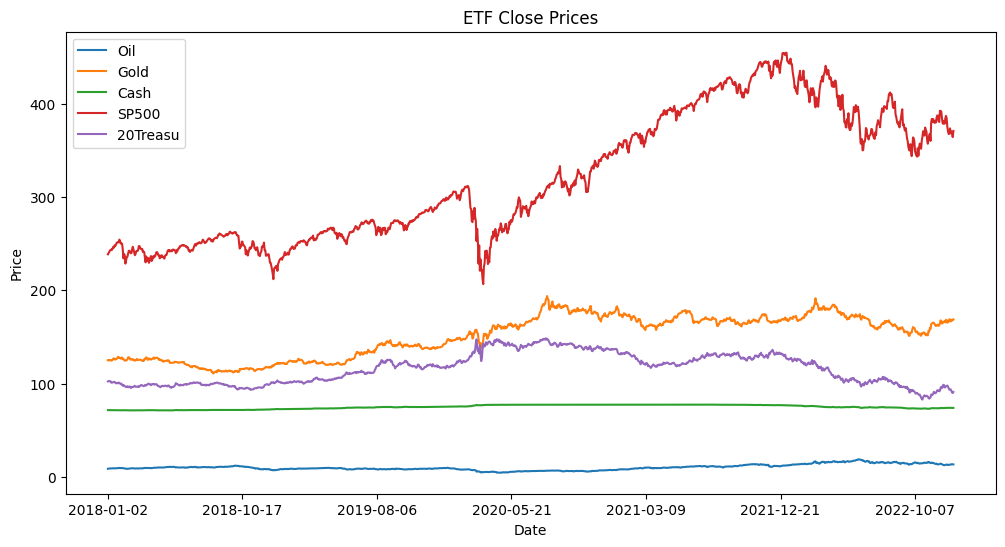

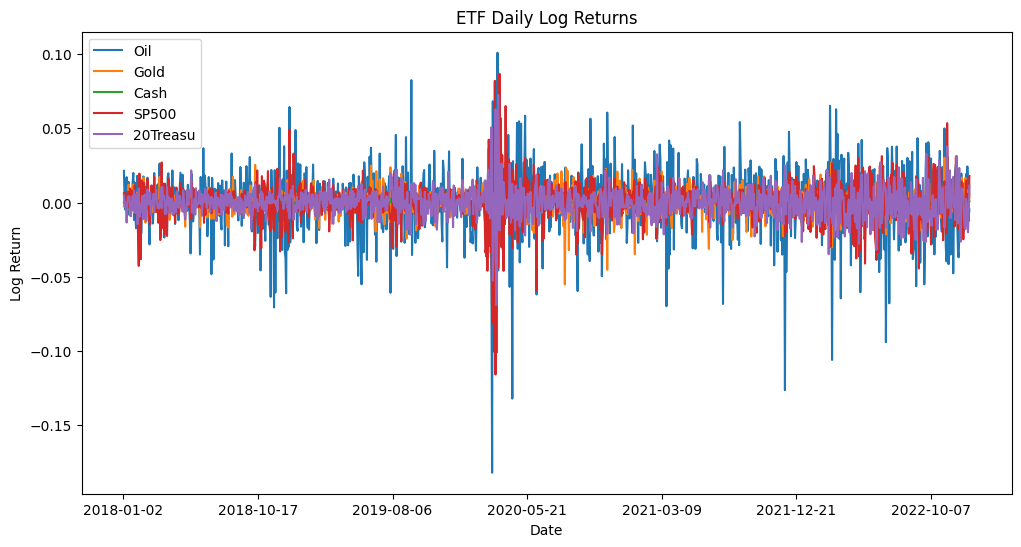

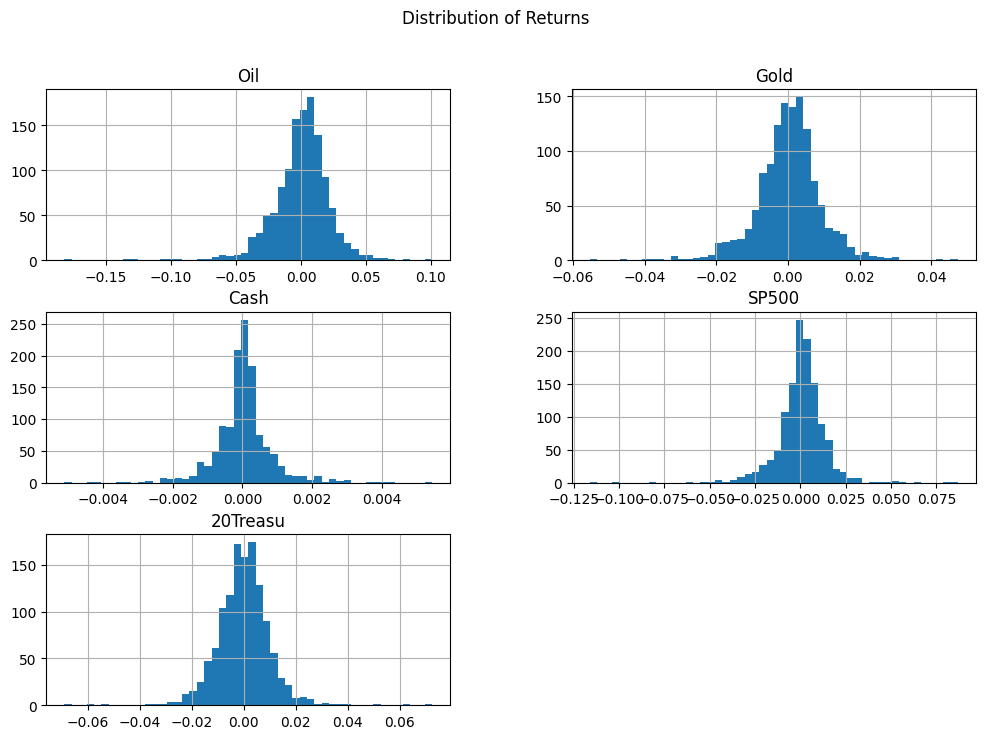

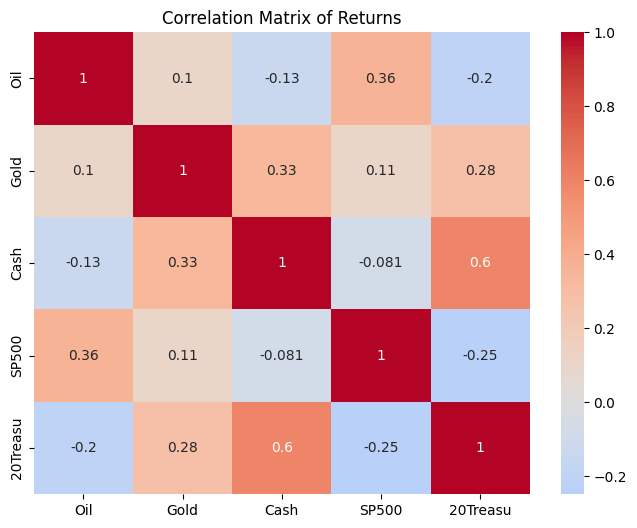

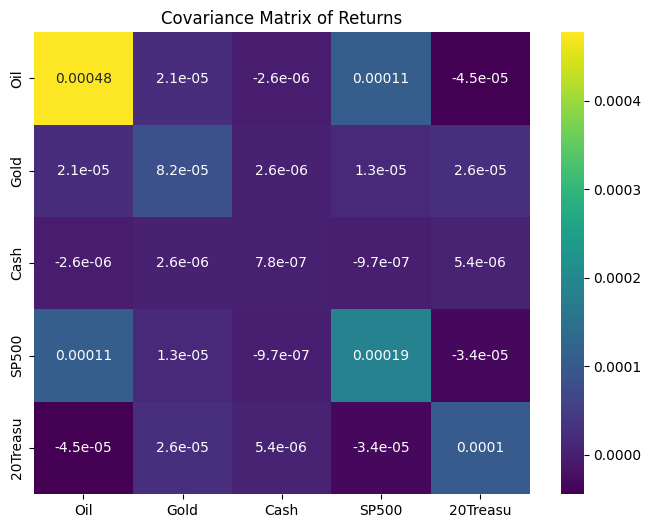

In [75]:
# --- 2. Visualizations ---

# Time series plots of prices
df.plot(figsize=(12,6), title="ETF Close Prices")
plt.ylabel("Price")
plt.show()

# Time series plots of returns
returns.plot(figsize=(12,6), title="ETF Daily Log Returns")
plt.ylabel("Log Return")
plt.show()

# Histograms of returns
returns.hist(bins=50, figsize=(12,8))
plt.suptitle("Distribution of Returns")
plt.show()

# Correlation heatmap of returns
plt.figure(figsize=(8,6))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Returns")
plt.show()

# Covariance heatmap of returns
plt.figure(figsize=(8,6))
sns.heatmap(returns.cov(), annot=True, cmap="viridis")
plt.title("Covariance Matrix of Returns")
plt.show()

In [76]:
# --- 3. Stationarity Tests ---
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test for {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print("Stationary" if result[1] < 0.05 else "Non-stationary")
    print('-'*40)

def kpss_test(series, title=''):
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
    print(f'KPSS Test for {title}')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print("Stationary" if p_value > 0.05 else "Non-stationary")
    print('-'*40)

print("\n=== Stationarity Tests ===")
for col in df.columns:
    adf_test(df[col], title=col + " Prices")
    kpss_test(df[col], title=col + " Prices")

for col in returns.columns:
    adf_test(returns[col], title=col + " Returns")
    kpss_test(returns[col], title=col + " Returns")


=== Stationarity Tests ===
ADF Test for Oil Prices
ADF Statistic: -0.9698491610109403
p-value: 0.7641017035991663
Non-stationary
----------------------------------------
KPSS Test for Oil Prices
KPSS Statistic: 2.7224088338588426
p-value: 0.01
Non-stationary
----------------------------------------
ADF Test for Gold Prices
ADF Statistic: -1.1950359294198687
p-value: 0.6757274759766653
Non-stationary
----------------------------------------
KPSS Test for Gold Prices
KPSS Statistic: 4.577756459886917
p-value: 0.01
Non-stationary
----------------------------------------
ADF Test for Cash Prices
ADF Statistic: -1.6196016945841438
p-value: 0.47293812043628464
Non-stationary
----------------------------------------
KPSS Test for Cash Prices
KPSS Statistic: 3.094906325337652
p-value: 0.01
Non-stationary
----------------------------------------
ADF Test for SP500 Prices
ADF Statistic: -1.1473971250496247
p-value: 0.6958053725713383
Non-stationary
----------------------------------------
KPSS 

/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of 

ADF Test for 20Treasu Prices
ADF Statistic: -0.718536614407508
p-value: 0.8418895360791463
Non-stationary
----------------------------------------
KPSS Test for 20Treasu Prices
KPSS Statistic: 1.5513897156093206
p-value: 0.01
Non-stationary
----------------------------------------
ADF Test for Oil Returns
ADF Statistic: -36.908588576281915
p-value: 0.0
Stationary
----------------------------------------
KPSS Test for Oil Returns
KPSS Statistic: 0.1385205148069635
p-value: 0.1
Stationary
----------------------------------------
ADF Test for Gold Returns
ADF Statistic: -15.417611716402677
p-value: 3.064528758333057e-28
Stationary
----------------------------------------
KPSS Test for Gold Returns
KPSS Statistic: 0.10070085614926423
p-value: 0.1
Stationary
----------------------------------------
ADF Test for Cash Returns
ADF Statistic: -6.670394904768834
p-value: 4.603502584287235e-09
Stationary
----------------------------------------
KPSS Test for Cash Returns
KPSS Statistic: 1.4076832

/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipython-input-779934894.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression='c', nlags="auto")


In [77]:
# creating the target variable - the 25 days look ahead cumulative return.

# Calculate 25-day cumulative return for each column (look ahead)
for col in ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu']:
    # Calculate daily percentage change
    daily_returns = df[col].pct_change()

    # Calculate 25-day cumulative return
    cumulative_returns_25d = (1 + daily_returns).rolling(window=25).apply(lambda x: x.prod() - 1)

    # Add the cumulative return as a new column, shifted to represent look-ahead
    df[f'Target {col}'] = cumulative_returns_25d.shift(-25)

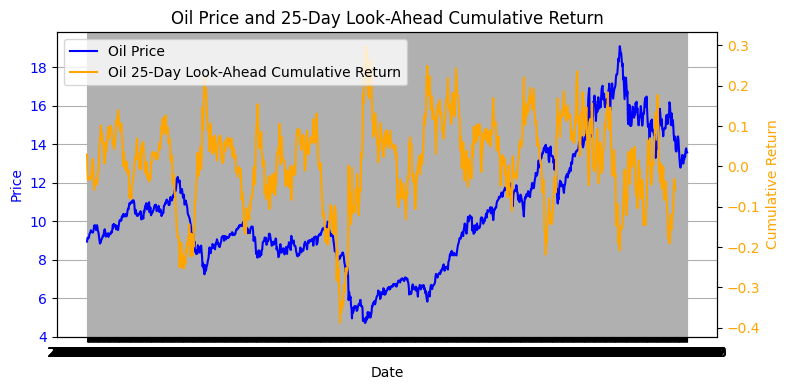

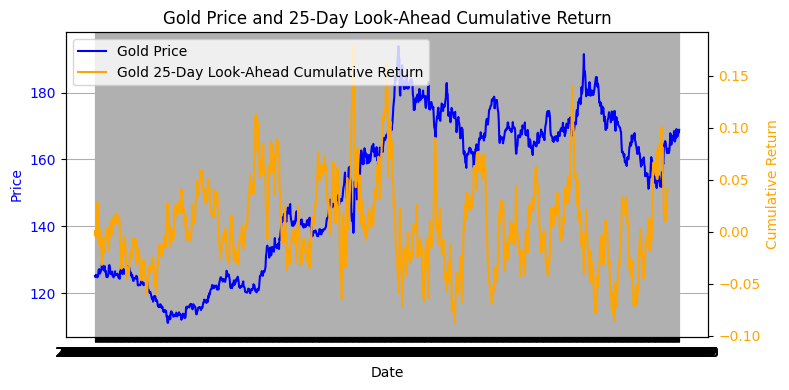

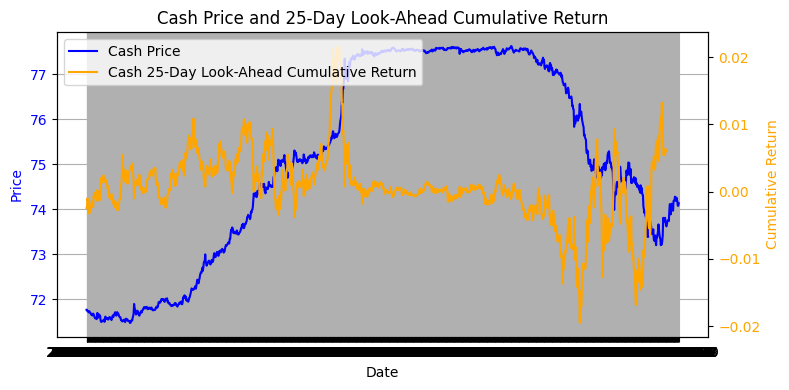

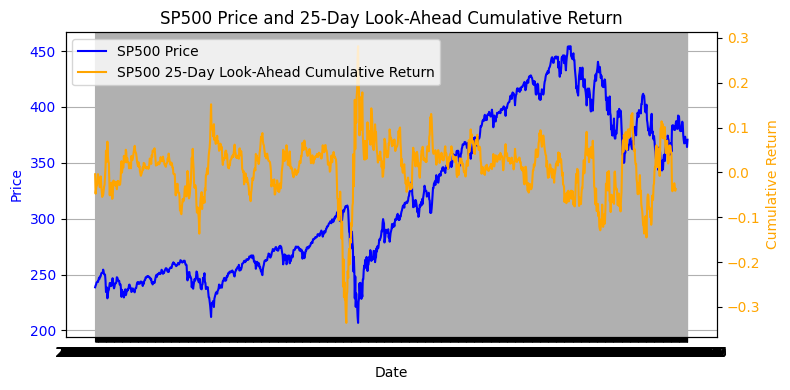

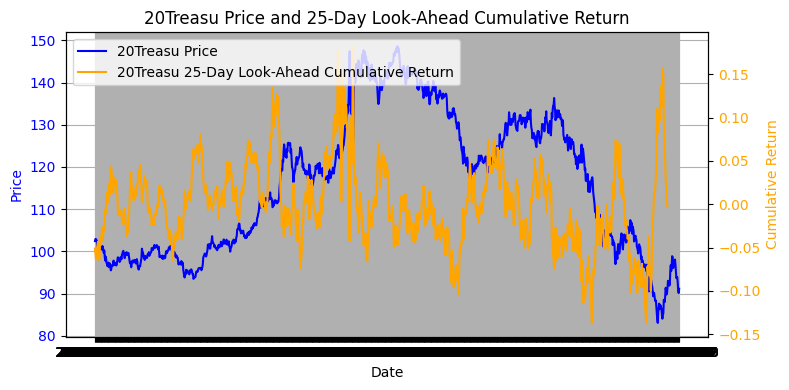

In [78]:
# Create a plot for each ETF with their price and cumulative return over time
etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu']

for etf in etfs:
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Plot price on primary y-axis
    ax1.plot(df.index, df[etf], label=f'{etf} Price', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f'{etf} Price and 25-Day Look-Ahead Cumulative Return')
    ax1.grid(True)

    # Create a secondary y-axis for cumulative return
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[f'Target {etf}'], label=f'{etf} 25-Day Look-Ahead Cumulative Return', color='orange')
    ax2.set_ylabel('Cumulative Return', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

We can observe, as expected, that the price level for each ETF present its own trend – while the target variable seems to be stationary. This can be further investigated by applying the Dickey Fuller unit root test. However, although stationarity can improve training algorithms for neural network, this can lose long term memory, which is undesirable when running recurrent network. Therefore, this group decided to keep the input as price levelled.

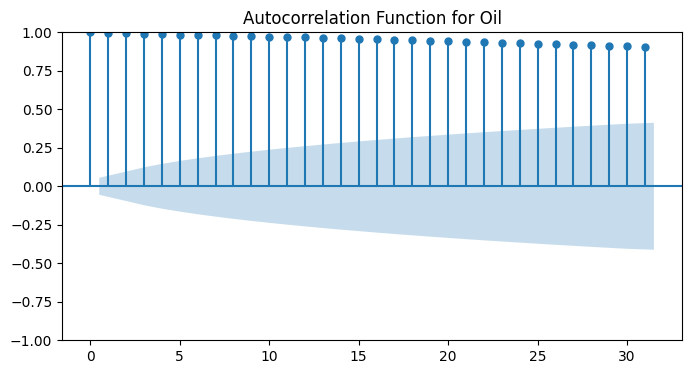

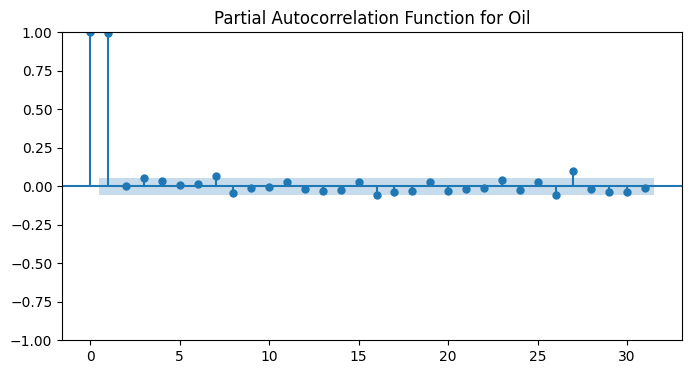

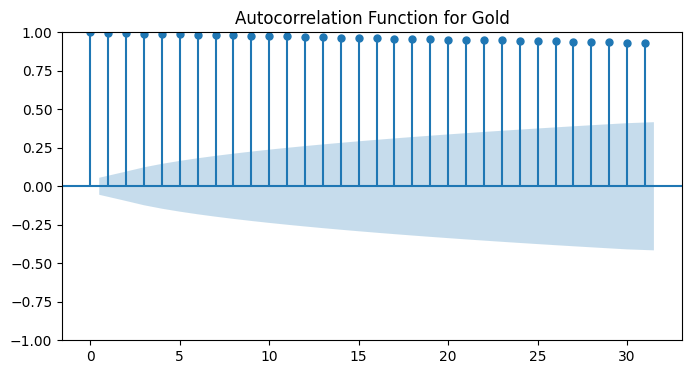

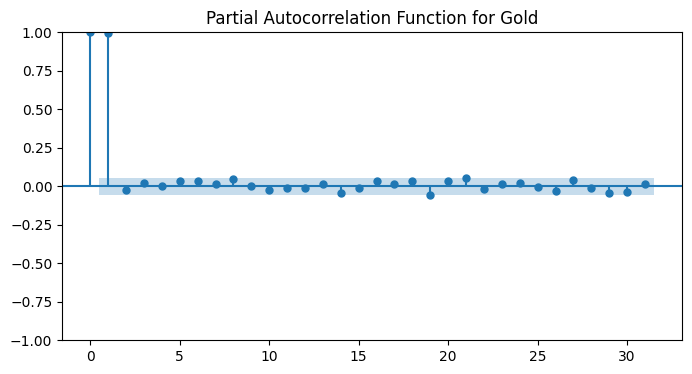

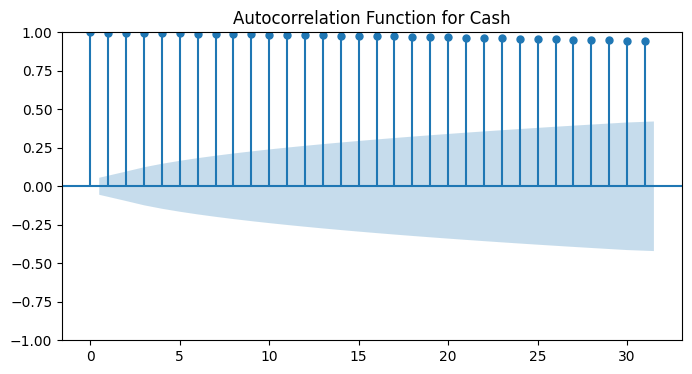

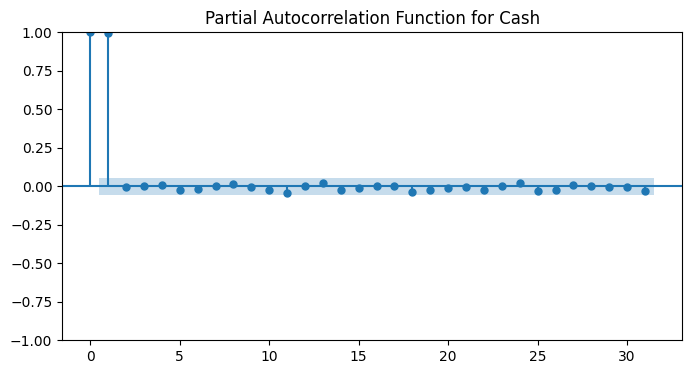

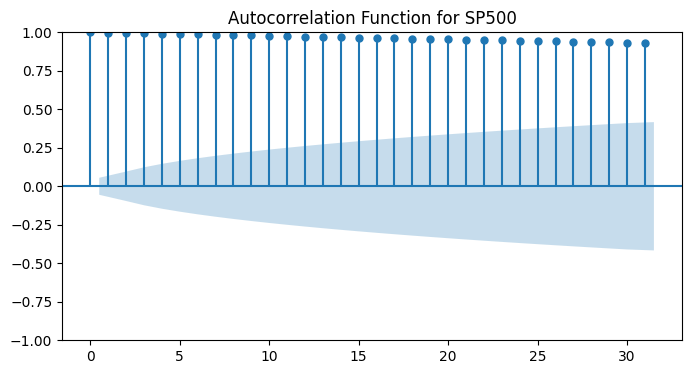

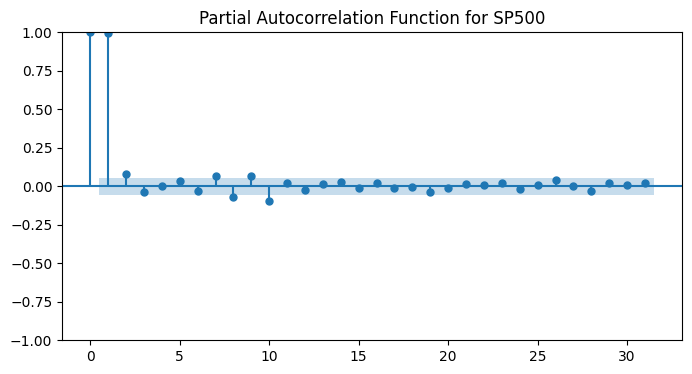

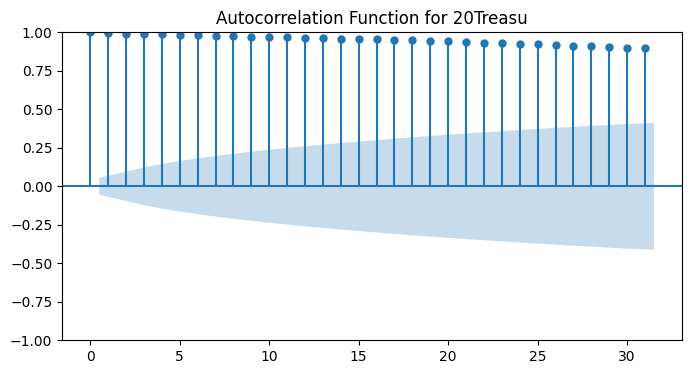

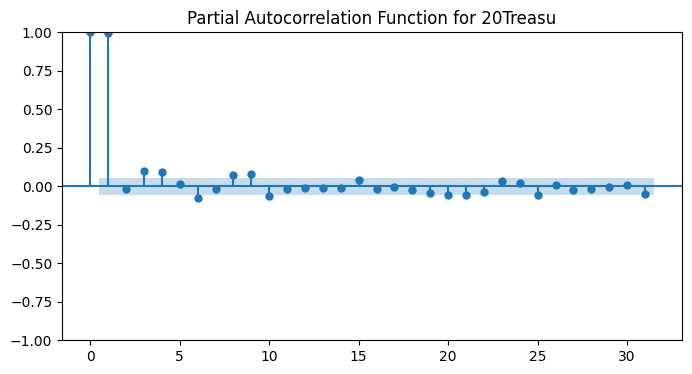

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu']

for etf in etfs:
    # ACF plot
    fig_acf, ax_acf = plt.subplots(figsize=(8, 4))
    plot_acf(df[etf].dropna(), ax=ax_acf, title=f'Autocorrelation Function for {etf}')
    plt.show()

    # PACF plot
    fig_pacf, ax_pacf = plt.subplots(figsize=(8, 4))
    plot_pacf(df[etf].dropna(), ax=ax_pacf, title=f'Partial Autocorrelation Function for {etf}')
    plt.show()


The autocorrelation graph confirms that each variable is correlated to its past values – the slow decay in the ACF plots is normally observed in nonstationary data and demonstrated strong correlation with many past values (potential trends and other patterns). The partial autocorrelation indicated that this lag is significant only on the first lag, which might indicate that short term memory will have a greater influence on the model’s performance. We hope that our recurrent networks are able to capture both, the long term pattern show on the ACF and the shorter.


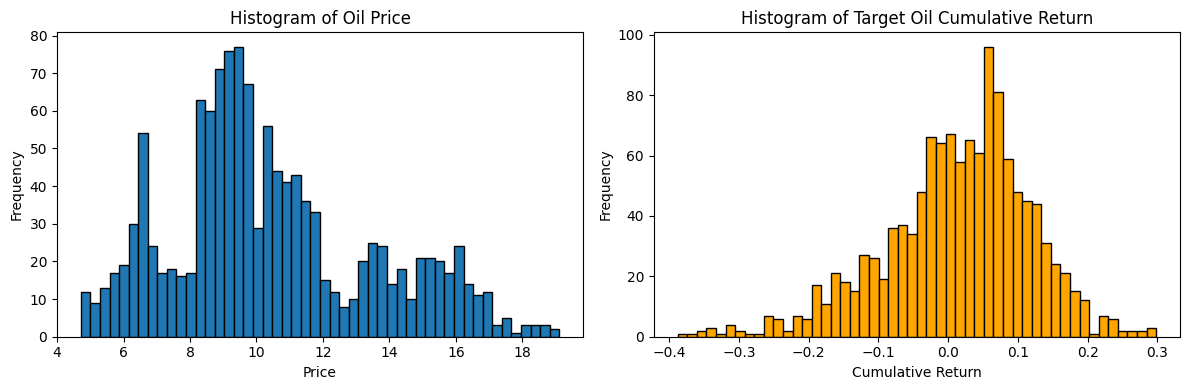

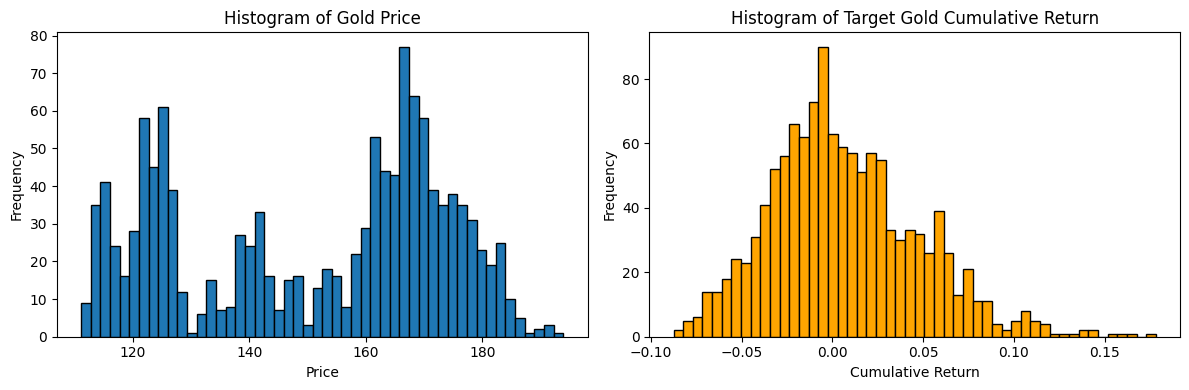

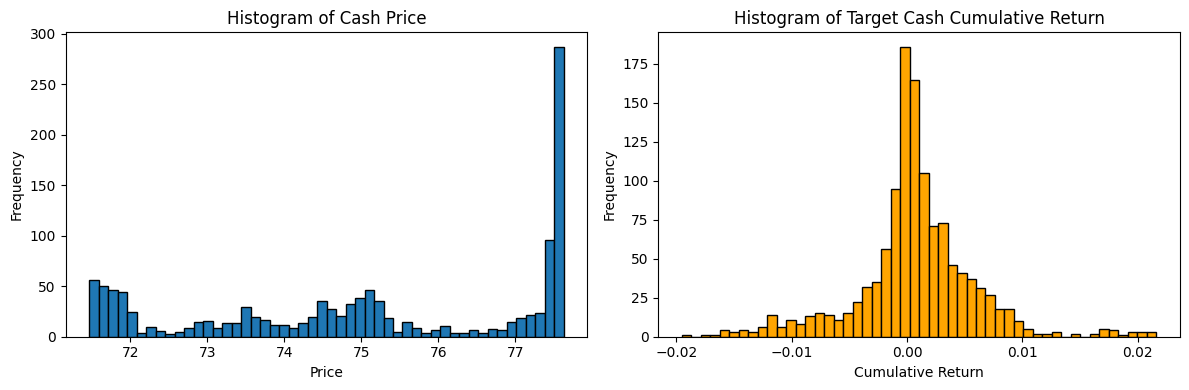

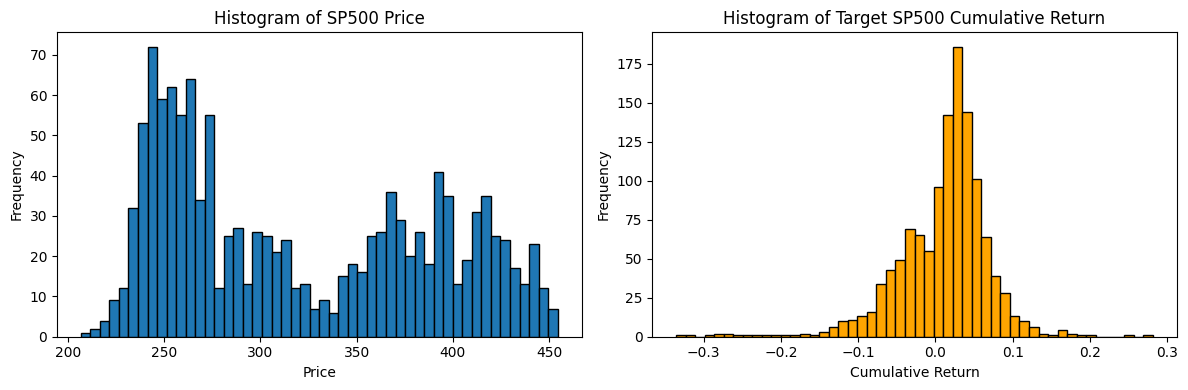

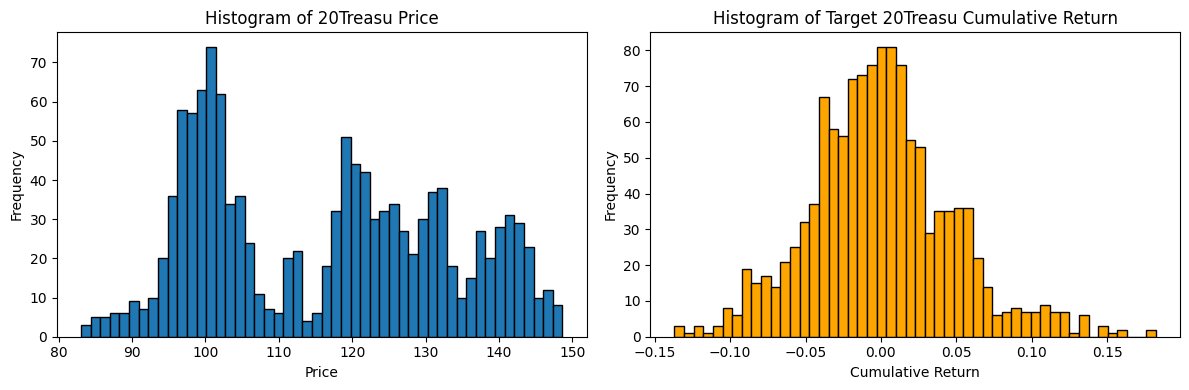

In [80]:
etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu']

for etf in etfs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot histogram for ETF price
    axes[0].hist(df[etf].dropna(), bins=50, edgecolor='black')
    axes[0].set_title(f'Histogram of {etf} Price')
    axes[0].set_xlabel('Price')
    axes[0].set_ylabel('Frequency')

    # Plot histogram for Target variable
    axes[1].hist(df[f'Target {etf}'].dropna(), bins=50, edgecolor='black', color='orange')
    axes[1].set_title(f'Histogram of Target {etf} Cumulative Return')
    axes[1].set_xlabel('Cumulative Return')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [81]:
display(df.describe())

,Oil,Gold,Cash,SP500,20Treasu,Target Oil,Target Gold,Target Cash,Target SP500,Target 20Treasu
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,10.410812,150.921431,75.098381,320.533193,116.077743,0.013099,0.006399,0.000679,0.010616,-0.000158
std,3.044787,22.501465,2.177710,68.837564,16.530819,0.105824,0.041042,0.005175,0.059517,0.047580
min,4.713807,111.099998,71.469757,206.683289,83.033531,-0.387892,-0.087596,-0.019522,-0.335720,-0.136968
25%,8.480901,125.865000,73.348803,257.457649,100.774157,-0.044660,-0.021757,-0.001033,-0.022917,-0.030364
50%,9.741605,159.434998,75.080772,302.544510,118.031841,0.025000,0.000980,0.000446,0.021100,-0.002297
75%,11.936356,169.345005,77.485687,384.727638,129.971554,0.081847,0.030781,0.003106,0.044099,0.025923
max,19.109049,193.889999,77.630379,454.466858,148.634293,0.298077,0.178209,0.021617,0.281588,0.182447


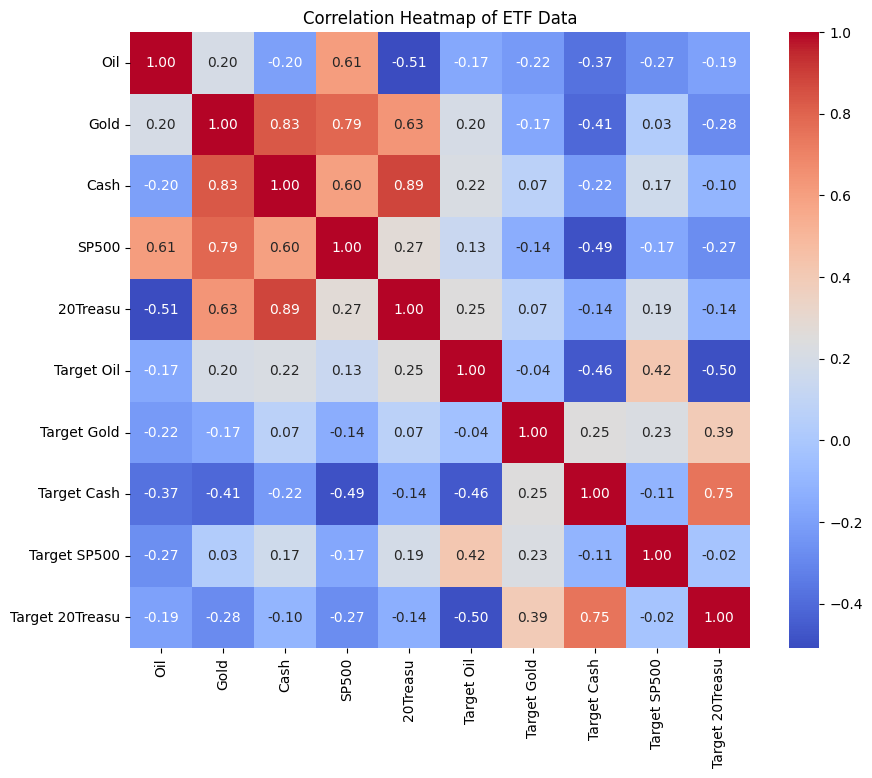

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of ETF Data')
plt.show()

For the single output models, we can observe that there is low correlation between the target variables and the feature - this might affect in the effectiveness of the model. On the contrary, if we consider the multi-output model, this will take into account other variables when predicting returns. The correlation between the features are gnarly high, which suggests that there will be an improvement in the output of the multi-algorithm in comparison with the single (“Multioutput Regression in Machine Learning”).


#**Step 2 - Separate LSTM Models for each ETF**

##**Preparing features and target variables**

* Features -  Past 25 prices
* target - 25 days look ahead cumulative return

In [83]:
df.head()

,Oil,Gold,Cash,SP500,20Treasu,Target Oil,Target Gold,Target Cash,Target SP500,Target 20Treasu
Date,,,,,,,,,,
2018-01-02,8.944057,125.150002,71.762192,238.568771,102.432419,0.029441,-0.002877,-0.002434,-0.004093,-0.051180
2018-01-03,9.137156,124.820000,71.762192,240.077728,102.922188,-0.012488,0.001282,-0.002315,-0.047473,-0.056729
2018-01-04,9.154711,125.459999,71.727898,241.089600,102.905869,-0.034516,-0.005500,-0.001001,-0.037222,-0.062540
2018-01-05,9.110826,125.330002,71.727898,242.696198,102.611992,-0.026012,0.000319,-0.001479,-0.029551,-0.055710
2018-01-08,9.163488,125.309998,71.727898,243.140060,102.546715,-0.027778,0.006145,-0.001479,-0.028914,-0.050882


In [84]:
#This function will create new target and feature variable with the past lenght for each etf.

def create_sequences(data, target, sequence_length):
    """
    Creates sequences of data and corresponding targets for time series forecasting.

    Args:
        data (pd.Series): The time series data (e.g., price).
        target (pd.Series): The target variable (e.g., cumulative return).
        sequence_length (int): The number of past days to use as features.

    Returns:
        tuple: A tuple containing:
            - X (np.ndarray): Sequences of features.
            - y (np.ndarray): Corresponding target values.
            - original_indices (pd.Index): Original indices of the created sequences.
    """
    X, y, original_indices = [], [], []
    for i in range(len(data) - sequence_length):
        # Check if the target value is NaN or infinity before appending
        if not (np.isnan(target.iloc[i + sequence_length]) or np.isinf(target.iloc[i + sequence_length])):
            X.append(data.iloc[i:(i + sequence_length)].values)
            y.append(target.iloc[i + sequence_length])
            original_indices.append(data.index[i + sequence_length])  # Store the original index

    return np.array(X), np.array(y), pd.Index(original_indices)

sequence_length = 25
X_data = {}
y_data = {}
original_indices_data = {}


etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu']

for etf in etfs:
    # Use the original price data for features and the target column for targets
    X_data[etf], y_data[etf], original_indices_data[etf] = create_sequences(df[etf], df[f'Target {etf}'], sequence_length)
    print(f"Prepared data for {etf}: X shape {X_data[etf].shape}, y shape {y_data[etf].shape}")

Prepared data for Oil: X shape (1208, 25), y shape (1208,)
Prepared data for Gold: X shape (1208, 25), y shape (1208,)
Prepared data for Cash: X shape (1208, 25), y shape (1208,)
Prepared data for SP500: X shape (1208, 25), y shape (1208,)
Prepared data for 20Treasu: X shape (1208, 25), y shape (1208,)


In [85]:
# Reshape features for LSTM input (samples, timesteps, features)
X_lstm = {}
for etf in etfs:
    X_lstm[etf] = X_data[etf].reshape((X_data[etf].shape[0], X_data[etf].shape[1], 1))
    print(f"Reshaped X data for {etf}: {X_lstm[etf].shape}")

# Reshape targets for LSTM output (samples, target_dimension)
y_lstm = {}
for etf in etfs:
    y_lstm[etf] = y_data[etf].reshape((y_data[etf].shape[0], 1))
    print(f"Reshaped y data for {etf}: {y_lstm[etf].shape}")

Reshaped X data for Oil: (1208, 25, 1)
Reshaped X data for Gold: (1208, 25, 1)
Reshaped X data for Cash: (1208, 25, 1)
Reshaped X data for SP500: (1208, 25, 1)
Reshaped X data for 20Treasu: (1208, 25, 1)
Reshaped y data for Oil: (1208, 1)
Reshaped y data for Gold: (1208, 1)
Reshaped y data for Cash: (1208, 1)
Reshaped y data for SP500: (1208, 1)
Reshaped y data for 20Treasu: (1208, 1)


The following dataset were created two dictionaries:

X_lstm: This is a dictionary where each key is an ETF name (like 'Oil', 'Gold', etc.), and the value is the reshaped NumPy array of features (past 25 days of prices) for that ETF. The shape of each array is (samples, timesteps, features).

y_lstm: This is also a dictionary with ETF names as keys. The values are the reshaped NumPy arrays of the target variables (25-day look-ahead cumulative returns) for each ETF. The shape of each array is (samples, target_dimension).

access the data for a specific ETF like this: X_lstm['Oil']

In [86]:
# visualize data

print(X_lstm['Oil'].shape)
X_lstm['Oil'][:2]

# Each row is a 3d array with past 25 prices from the ETF over time.

(1208, 25, 1)


array([[[8.94405651],
        [9.13715649],
        [9.15471077],
        [9.11082554],
        [9.16348839],
        [9.3214798 ],
        [9.38292027],
        [9.4004755 ],
        [9.53213406],
        [9.45313931],
        [9.45313931],
        [9.43558407],
        [9.40925312],
        [9.45313931],
        [9.58479786],
        [9.77789974],
        [9.66379356],
        [9.79545307],
        [9.7076807 ],
        [9.54091167],
        [9.61990738],
        [9.79545307],
        [9.65501595],
        [9.47069454],
        [9.40925312]],

       [[9.13715649],
        [9.15471077],
        [9.11082554],
        [9.16348839],
        [9.3214798 ],
        [9.38292027],
        [9.4004755 ],
        [9.53213406],
        [9.45313931],
        [9.45313931],
        [9.43558407],
        [9.40925312],
        [9.45313931],
        [9.58479786],
        [9.77789974],
        [9.66379356],
        [9.79545307],
        [9.7076807 ],
        [9.54091167],
        [9.61990738],
        

In [87]:
import numpy as np

X_lstm_training = {}
X_lstm_validation = {}
X_lstm_test = {}
y_lstm_training = {}
y_lstm_validation = {}
y_lstm_test = {}

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu'] # Assuming etfs list is available
# Assuming X_lstm and y_lstm dictionaries are available from previous steps

for etf in etfs:
    X = X_lstm[etf]
    y = y_lstm[etf]

    total_samples = len(X)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    test_size = total_samples - train_size - val_size

    X_lstm_training[etf] = X[:train_size]
    y_lstm_training[etf] = y[:train_size]

    X_lstm_validation[etf] = X[train_size:train_size + val_size]
    y_lstm_validation[etf] = y[train_size:train_size + val_size]

    X_lstm_test[etf] = X[train_size + val_size:]
    y_lstm_test[etf] = y[train_size + val_size:]

# Print shapes to verify the split
for etf in etfs:
    print(f"Data splits for {etf}:")
    print(f"  Train: X shape {X_lstm_training[etf].shape}, y shape {y_lstm_training[etf].shape}")
    print(f"  Validation: X shape {X_lstm_validation[etf].shape}, y shape {y_lstm_validation[etf].shape}")
    print(f"  Test: X shape {X_lstm_test[etf].shape}, y shape {y_lstm_test[etf].shape}")

Data splits for Oil:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Data splits for Gold:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Data splits for Cash:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Data splits for SP500:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Data splits for 20Treasu:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)


**New created data variables:**

X_lstm_training, X_lstm_validation, X_lstm_test, y_lstm_training, y_lstm_validation, and y_lstm_test

The new variables were created for our LSTM models - to call any just use:

X_lstm_training['Gold']


###**Scaling dataset**

Our work decided to scale both, feature and target variables, this will improve convergence – as features and target are same scale. It also helps to make output range consistent withing a defined range and improve hyperparameter tuning. We using scale between -1 and 1, as the sign would matter for the current problem at hand.


In [88]:
from sklearn.preprocessing import MinMaxScaler

X_lstm_training_scaled = {}
X_lstm_validation_scaled = {}
X_lstm_test_scaled = {}
y_lstm_training_scaled = {}
y_lstm_validation_scaled = {}
y_lstm_test_scaled = {}


scalers_X = {}
scalers_y = {}

for etf in etfs:
    # Scale features
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    # Reshape X_lstm_training[etf] to 2D for fitting
    X_train_reshaped = X_lstm_training[etf].reshape(-1, X_lstm_training[etf].shape[-1])
    X_lstm_training_scaled[etf] = scaler_X.fit_transform(X_train_reshaped).reshape(X_lstm_training[etf].shape)
    scalers_X[etf] = scaler_X # Save the scaler

    # Reshape validation and test features and transform
    X_val_reshaped = X_lstm_validation[etf].reshape(-1, X_lstm_validation[etf].shape[-1])
    X_lstm_validation_scaled[etf] = scaler_X.transform(X_val_reshaped).reshape(X_lstm_validation[etf].shape)


    X_test_reshaped = X_lstm_test[etf].reshape(-1, X_lstm_test[etf].shape[-1])
    X_lstm_test_scaled[etf] = scaler_X.transform(X_test_reshaped).reshape(X_lstm_test[etf].shape)

    # Scale targets
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_lstm_training_scaled[etf] = scaler_y.fit_transform(y_lstm_training[etf])
    scalers_y[etf] = scaler_y # Save the scaler

    y_lstm_validation_scaled[etf] = scaler_y.transform(y_lstm_validation[etf])
    y_lstm_test_scaled[etf] = scaler_y.transform(y_lstm_test[etf])


# Print shapes to verify scaling and reshaping
for etf in etfs:
    print(f"Scaled data shapes for {etf}:")
    print(f"  Train: X shape {X_lstm_training_scaled[etf].shape}, y shape {y_lstm_training_scaled[etf].shape}")
    print(f"  Validation: X shape {X_lstm_validation_scaled[etf].shape}, y shape {y_lstm_validation_scaled[etf].shape}")
    print(f"  Test: X shape {X_lstm_test_scaled[etf].shape}, y shape {y_lstm_test_scaled[etf].shape}")

Scaled data shapes for Oil:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Scaled data shapes for Gold:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Scaled data shapes for Cash:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Scaled data shapes for SP500:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)
Scaled data shapes for 20Treasu:
  Train: X shape (966, 25, 1), y shape (966, 1)
  Validation: X shape (120, 25, 1), y shape (120, 1)
  Test: X shape (122, 25, 1), y shape (122, 1)


In [89]:
df[etfs]

,Oil,Gold,Cash,SP500,20Treasu
Date,,,,,
2018-01-02,8.944057,125.150002,71.762192,238.568771,102.432419
2018-01-03,9.137156,124.820000,71.762192,240.077728,102.922188
2018-01-04,9.154711,125.459999,71.727898,241.089600,102.905869
2018-01-05,9.110826,125.330002,71.727898,242.696198,102.611992
2018-01-08,9.163488,125.309998,71.727898,243.140060,102.546715
...,...,...,...,...,...
2022-12-22,13.364376,166.759995,74.214691,368.071991,93.848289
2022-12-23,13.693008,167.259995,74.178177,370.189240,92.472404
2022-12-27,13.793423,168.669998,74.077858,368.729370,90.643959


##LSTM models for each ETF

Next steps:

* Define LSTM model
* Define callbacks
    - Model Checkpoint
    - Earlystop
* Train and save each model
* Compare models

In [90]:
# seed our model for reproducibility

import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

SEED = 10716 #Groups number
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [91]:
# Define model layout


# For your data: 25 timesteps (past days), 1 feature (scaled price)
INPUT_SHAPE = (25, 1)

# Define the LSTM model architecture
model = Sequential()

# First LSTM layer
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=INPUT_SHAPE))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# Second LSTM layer
# return_sequences=True because the output is fed into another LSTM layer
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(Dropout(0.2)) # Another Dropout layer

# Third LSTM layer
# return_sequences=False because it's the last LSTM layer before the Dense output layer
model.add(LSTM(units=16, activation='tanh', return_sequences=False))
model.add(Dropout(0.2)) # Another Dropout layer

# Add one fully connected Dense layer
model.add(Dense(units=16, activation='relu')) # Dense layer with 30 units and ReLU activation

# Add second Dense
model.add(Dense(units=8, activation='relu')) # Another Dense layer with 15 units and ReLU activation

# Output layer
model.add(Dense(units=1)) # Dense layer with 1 unit for regression output

# Compile the model
hp_lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error")

# Print model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 25, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,865 (128.38 KB)

 Trainable params: 32,865 (128.38 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
#Defining calbakc and earlystopping

from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Directory to save best models
model_save_dir = 'best_lstm_models'
os.makedirs(model_save_dir, exist_ok=True)

# Define ModelCheckpoint callback
# This callback will save the best model based on validation loss
# A placeholder for the filepath is used here; it will be updated for each ETF
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_save_dir, 'best_model.h5'), # Placeholder filepath
    monitor='val_loss', # Monitor validation loss
    save_best_only=True, # Save only the best model
    mode='min', # Save when validation loss is minimum
    verbose=1 # Print messages when a model is saved
)

# Define EarlyStopping callback
# This callback will stop training if validation loss doesn't improve for a certain number of epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10, # Stop after 10 epochs of no improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

print(f"Callbacks defined. Best models will be saved to '{model_save_dir}' directory.")

Callbacks defined. Best models will be saved to 'best_lstm_models' directory.


###Run model for each ETF

In [93]:
# run models

# Dictionary to store trained models and training history
trained_lstm_models = {}
training_history = {}
best_model_paths = {}

etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu'] # Assuming etfs list is available

for etf in etfs:
    print(f"Training LSTM model for {etf}...")

    # Clone the model architecture for independent training
    # This creates a new model with the same architecture and initial weights
    etf_model = tf.keras.models.clone_model(model)
    etf_model.compile(optimizer='adam', loss='mse') # Compile the cloned model

    # Update the filepath for ModelCheckpoint to be unique for each ETF
    etf_checkpoint_path = os.path.join(model_save_dir, f'best_{etf}_lstm_model.h5')
    etf_model_checkpoint_callback = ModelCheckpoint(
        filepath=etf_checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Combine callbacks for training
    callbacks_list = [etf_model_checkpoint_callback, early_stopping_callback]

    # Train the model for the current ETF
    history = etf_model.fit(
        X_lstm_training_scaled[etf],
        y_lstm_training_scaled[etf],
        epochs=100, # Adjust epochs as needed
        batch_size=32, # Adjust batch size as needed
        validation_data=(X_lstm_validation_scaled[etf], y_lstm_validation_scaled[etf]),
        callbacks=callbacks_list,
        verbose=0 # Set to 1 to see training progress
    )

    # Store the trained model and history
    # Note: The best model is saved to etf_checkpoint_path by the callback
    trained_lstm_models[etf] = etf_model
    training_history[etf] = history
    best_model_paths[etf] = etf_checkpoint_path # Store the path to the saved best model

    print(f"Training finished for {etf}. Best model saved to {best_model_paths[etf]}")
    print("-" * 30)

Training LSTM model for Oil...

Epoch 1: val_loss improved from inf to 0.19301, saving model to best_lstm_models/best_Oil_lstm_model.h5



Epoch 2: val_loss improved from 0.19301 to 0.19297, saving model to best_lstm_models/best_Oil_lstm_model.h5



Epoch 3: val_loss improved from 0.19297 to 0.18746, saving model to best_lstm_models/best_Oil_lstm_model.h5



Epoch 4: val_loss did not improve from 0.18746

Epoch 5: val_loss did not improve from 0.18746

Epoch 6: val_loss did not improve from 0.18746

Epoch 7: val_loss did not improve from 0.18746

Epoch 8: val_loss did not improve from 0.18746

Epoch 9: val_loss did not improve from 0.18746

Epoch 10: val_loss did not improve from 0.18746

Epoch 11: val_loss did not improve from 0.18746

Epoch 12: val_loss did not improve from 0.18746

Epoch 13: val_loss did not improve from 0.18746
Training finished for Oil. Best model saved to best_lstm_models/best_Oil_lstm_model.h5
------------------------------
Training LSTM model for Gold...

Epoch 1: val_loss improved from inf to 0.08887, saving model to best_lstm_models/best_Gold_lstm_model.h5



Epoch 2: val_loss improved from 0.08887 to 0.08263, saving model to best_lstm_models/best_Gold_lstm_model.h5



Epoch 3: val_loss did not improve from 0.08263

Epoch 4: val_loss did not improve from 0.08263

Epoch 5: val_loss did not improve from 0.08263

Epoch 6: val_loss did not improve from 0.08263

Epoch 7: val_loss did not improve from 0.08263

Epoch 8: val_loss did not improve from 0.08263

Epoch 9: val_loss did not improve from 0.08263

Epoch 10: val_loss did not improve from 0.08263

Epoch 11: val_loss did not improve from 0.08263

Epoch 12: val_loss did not improve from 0.08263
Training finished for Gold. Best model saved to best_lstm_models/best_Gold_lstm_model.h5
------------------------------
Training LSTM model for Cash...

Epoch 1: val_loss improved from inf to 0.62959, saving model to best_lstm_models/best_Cash_lstm_model.h5



Epoch 2: val_loss improved from 0.62959 to 0.53034, saving model to best_lstm_models/best_Cash_lstm_model.h5



Epoch 3: val_loss did not improve from 0.53034

Epoch 4: val_loss did not improve from 0.53034

Epoch 5: val_loss did not improve from 0.53034

Epoch 6: val_loss did not improve from 0.53034

Epoch 7: val_loss did not improve from 0.53034

Epoch 8: val_loss did not improve from 0.53034

Epoch 9: val_loss did not improve from 0.53034

Epoch 10: val_loss did not improve from 0.53034

Epoch 11: val_loss did not improve from 0.53034

Epoch 12: val_loss did not improve from 0.53034
Training finished for Cash. Best model saved to best_lstm_models/best_Cash_lstm_model.h5
------------------------------
Training LSTM model for SP500...

Epoch 1: val_loss improved from inf to 0.06974, saving model to best_lstm_models/best_SP500_lstm_model.h5



Epoch 2: val_loss improved from 0.06974 to 0.06569, saving model to best_lstm_models/best_SP500_lstm_model.h5



Epoch 3: val_loss improved from 0.06569 to 0.06155, saving model to best_lstm_models/best_SP500_lstm_model.h5



Epoch 4: val_loss improved from 0.06155 to 0.05747, saving model to best_lstm_models/best_SP500_lstm_model.h5



Epoch 5: val_loss did not improve from 0.05747

Epoch 6: val_loss did not improve from 0.05747

Epoch 7: val_loss did not improve from 0.05747

Epoch 8: val_loss did not improve from 0.05747

Epoch 9: val_loss did not improve from 0.05747

Epoch 10: val_loss did not improve from 0.05747

Epoch 11: val_loss did not improve from 0.05747

Epoch 12: val_loss did not improve from 0.05747

Epoch 13: val_loss did not improve from 0.05747

Epoch 14: val_loss did not improve from 0.05747
Training finished for SP500. Best model saved to best_lstm_models/best_SP500_lstm_model.h5
------------------------------
Training LSTM model for 20Treasu...

Epoch 1: val_loss improved from inf to 0.23671, saving model to best_lstm_models/best_20Treasu_lstm_model.h5



Epoch 2: val_loss did not improve from 0.23671

Epoch 3: val_loss did not improve from 0.23671

Epoch 4: val_loss did not improve from 0.23671

Epoch 5: val_loss did not improve from 0.23671

Epoch 6: val_loss did not improve from 0.23671

Epoch 7: val_loss did not improve from 0.23671

Epoch 8: val_loss did not improve from 0.23671

Epoch 9: val_loss did not improve from 0.23671

Epoch 10: val_loss did not improve from 0.23671

Epoch 11: val_loss did not improve from 0.23671
Training finished for 20Treasu. Best model saved to best_lstm_models/best_20Treasu_lstm_model.h5
------------------------------


###Calculating predicted values for each ETF

In [94]:
# Assuming best_model_paths, X_lstm_training_scaled, X_lstm_validation_scaled,
# X_lstm_test_scaled, scalers_y, and etfs are available

# Dictionary to store predictions for the entire dataset
full_predictions = {}

print("Calculating predictions for the entire dataset for each model:")

for etf in etfs:
    print(f"Making predictions for {etf} model on the entire dataset...")

    # Load the best saved model for the current ETF
    model_path = best_model_paths[etf]
    best_model = tf.keras.models.load_model(
        model_path,
        custom_objects={'mean_absolute_error': tf.keras.losses.MeanAbsoluteError, 'mse': tf.keras.losses.MeanSquaredError}
    )

    # Concatenate the scaled training, validation, and test features to get the full scaled dataset
    X_full_scaled = np.concatenate([
        X_lstm_training_scaled[etf],
        X_lstm_validation_scaled[etf],
        X_lstm_test_scaled[etf]
    ], axis=0)


    # Make predictions on the full scaled dataset
    full_predictions_scaled = best_model.predict(X_full_scaled)

    # Inverse transform the scaled predictions back to the original scale
    full_predictions_original_scale = scalers_y[etf].inverse_transform(full_predictions_scaled)

    # Store the predictions
    full_predictions[etf] = full_predictions_original_scale


    print(f"  Predictions calculated for the entire dataset for {etf}.")
    print("-" * 30)

# You can access the full predictions for an ETF like: full_predictions['Oil']

Calculating predictions for the entire dataset for each model:
Making predictions for Oil model on the entire dataset...


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
  Predictions calculated for the entire dataset for Oil.
------------------------------
Making predictions for Gold model on the entire dataset...


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


  Predictions calculated for the entire dataset for Gold.
------------------------------
Making predictions for Cash model on the entire dataset...
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


  Predictions calculated for the entire dataset for Cash.
------------------------------
Making predictions for SP500 model on the entire dataset...
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


  Predictions calculated for the entire dataset for SP500.
------------------------------
Making predictions for 20Treasu model on the entire dataset...
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
  Predictions calculated for the entire dataset for 20Treasu.
------------------------------


###Calculating loss for each test dataset

In [95]:
# Calculate test loss for each ETF model
test_loss_data = {}

print("Calculating test loss for each ETF model:")

for etf in etfs:
    print(f"Calculating test loss for {etf}...")

    # Load the best saved model for the current ETF
    model_path = best_model_paths[etf]
    best_model = tf.keras.models.load_model(
        model_path,
        custom_objects={'mean_absolute_error': tf.keras.losses.MeanAbsoluteError, 'mse': tf.keras.losses.MeanSquaredError}
    )

    # Check for NaNs in the test data before evaluation
    if np.any(np.isnan(X_lstm_test_scaled[etf])) or np.any(np.isinf(X_lstm_test_scaled[etf])):
        print(f"  Warning: X_lstm_test_scaled[{etf}] contains NaN or Infinite values before evaluation.")
    if np.any(np.isnan(y_lstm_test_scaled[etf])) or np.any(np.isinf(y_lstm_test_scaled[etf])):
        print(f"  Warning: y_lstm_test_scaled[{etf}] contains NaN or Infinite values before evaluation.")


    # Evaluate the model on the scaled test data
    loss = best_model.evaluate(X_lstm_test_scaled[etf], y_lstm_test_scaled[etf], verbose=0)

    # Store the test loss
    test_loss_data[etf] = loss

    print(f"  Test loss for {etf}: {loss}")
    print("-" * 30)

# You can access the test loss for an ETF like: test_loss_data['Oil']

Calculating test loss for each ETF model:
Calculating test loss for Oil...


  Test loss for Oil: 0.06039222329854965
------------------------------
Calculating test loss for Gold...


  Test loss for Gold: 0.11226896196603775
------------------------------
Calculating test loss for Cash...


  Test loss for Cash: 0.49264436960220337
------------------------------
Calculating test loss for SP500...


  Test loss for SP500: 0.05590352416038513
------------------------------
Calculating test loss for 20Treasu...
  Test loss for 20Treasu: 0.2822170853614807
------------------------------


###**Comparing models**

Generating plots for actual vs. predicted cumulative returns:
Generating plot for Oil...


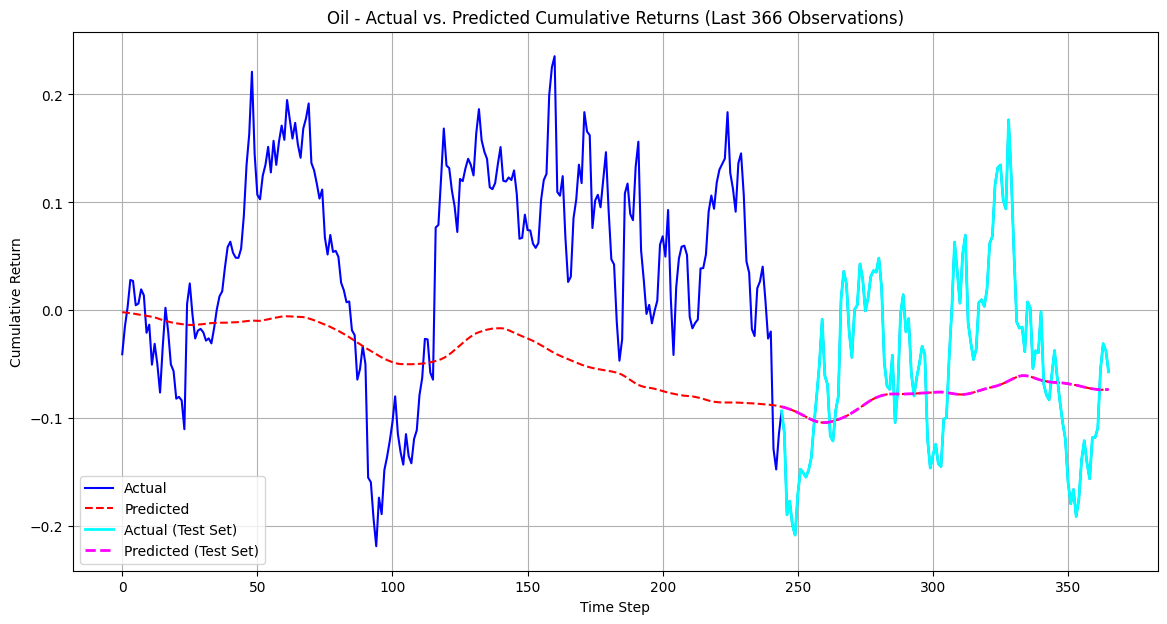

  Plot generated for Oil.
------------------------------
Generating plot for Gold...


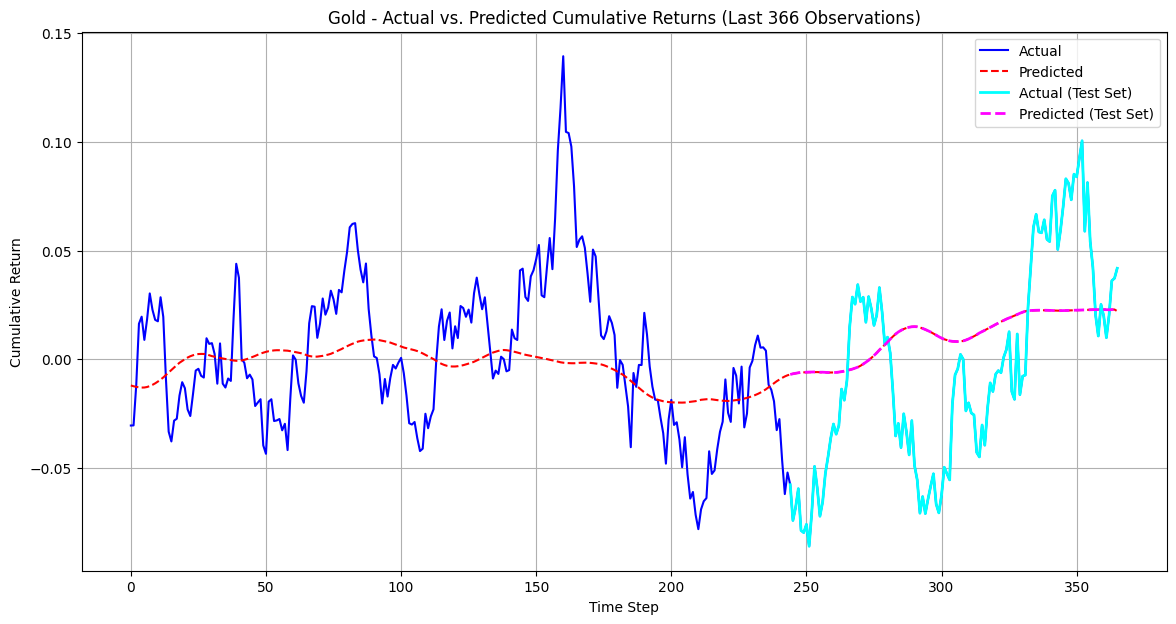

  Plot generated for Gold.
------------------------------
Generating plot for Cash...


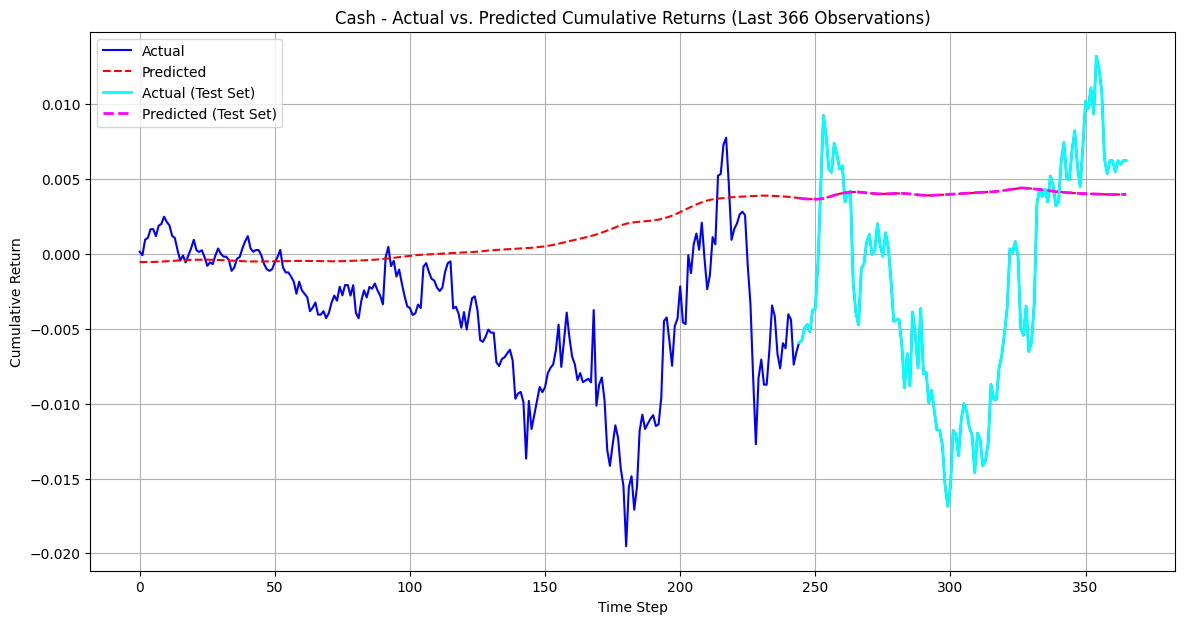

  Plot generated for Cash.
------------------------------
Generating plot for SP500...


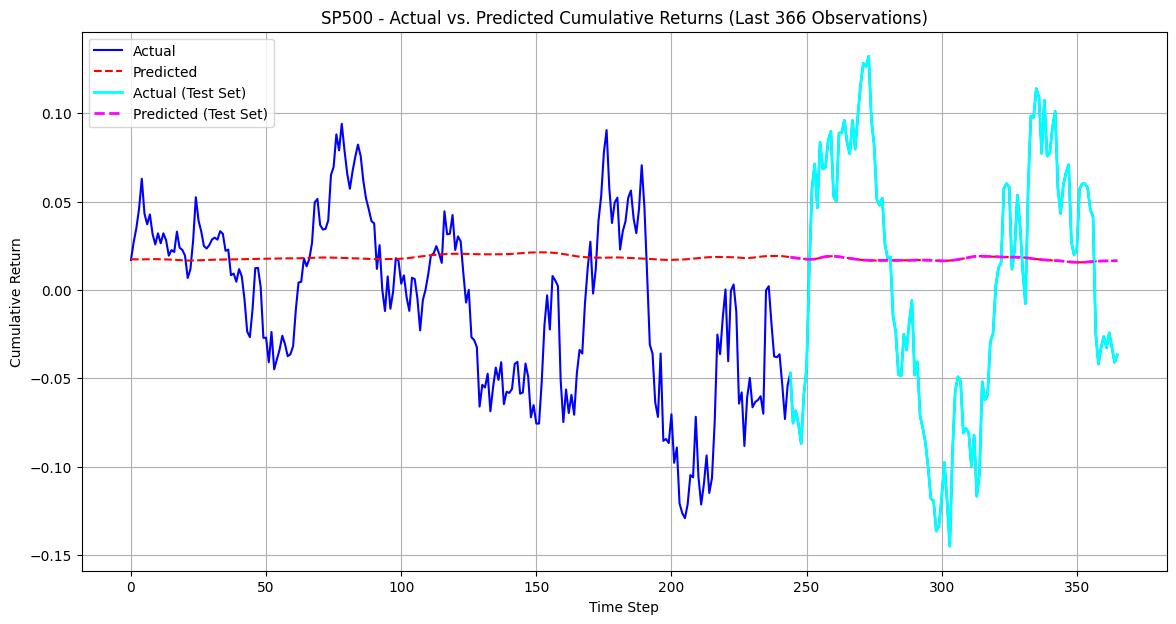

  Plot generated for SP500.
------------------------------
Generating plot for 20Treasu...


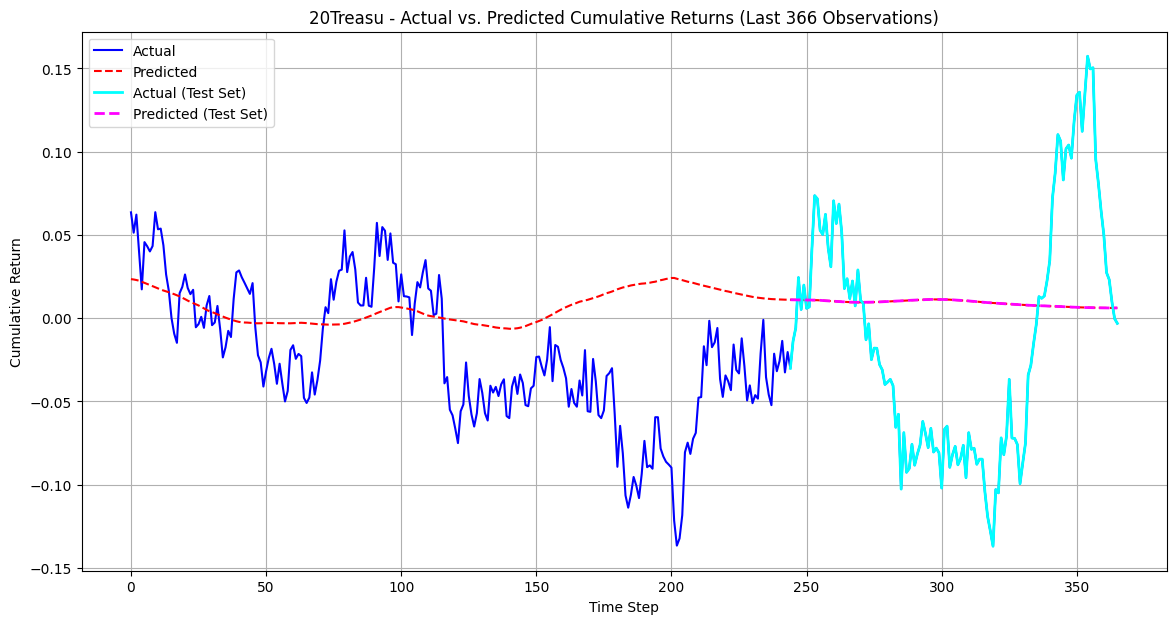

  Plot generated for 20Treasu.
------------------------------


In [96]:
import matplotlib.pyplot as plt

# Assuming y_lstm (actual targets) and full_predictions (predictions) are available
# Assuming etfs list is available

# Number of observations in the test set (calculated in the splitting step)
test_size = 122
# Number of observations from the training/validation set to include before the test set
train_val_predict_length = 122 * 2 # To get a total of 122 * 3 = 366 observations

print("Generating plots for actual vs. predicted cumulative returns:")

for etf in etfs:
    print(f"Generating plot for {etf}...")

    # Get the actual target values for the full dataset
    # Concatenate the original (unscaled) y splits to get the full actual values
    y_full_actual = np.concatenate([
        y_lstm_training[etf],
        y_lstm_validation[etf],
        y_lstm_test[etf]
    ], axis=0)

    # Get the predictions for the full dataset
    predictions_full = full_predictions[etf]

    # Select the last 'train_val_predict_length + test_size' observations
    start_index = len(y_full_actual) - (train_val_predict_length + test_size)
    end_index = len(y_full_actual)

    actual_subset = y_full_actual[start_index:end_index]
    predictions_subset = predictions_full[start_index:end_index]

    # Get the corresponding date index for the subset
    # Assuming the original df index can be used or a similar index is available
    # We need to be careful with the index alignment after sequence creation and splitting.
    # A simpler approach for plotting might be to just use a numerical index for the subset.
    # Let's use a numerical index for simplicity here.

    plt.figure(figsize=(14, 7))

    # Plot actual and predicted values for the entire subset
    plt.plot(range(len(actual_subset)), actual_subset, label='Actual', color='blue')
    plt.plot(range(len(predictions_subset)), predictions_subset, label='Predicted', color='red', linestyle='--')

    # Highlight the test set portion with different colors
    test_start_index_in_subset = train_val_predict_length
    plt.plot(range(test_start_index_in_subset, len(actual_subset)), actual_subset[test_start_index_in_subset:], label='Actual (Test Set)', color='cyan', linewidth=2)
    plt.plot(range(test_start_index_in_subset, len(predictions_subset)), predictions_subset[test_start_index_in_subset:], label='Predicted (Test Set)', color='magenta', linestyle='--', linewidth=2)


    plt.title(f'{etf} - Actual vs. Predicted Cumulative Returns (Last {train_val_predict_length + test_size} Observations)')
    plt.xlabel('Time Step') # Using time step as index for simplicity
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"  Plot generated for {etf}.")
    print("-" * 30)

In [97]:
# Comparing model losses

comparison_data = {}

etfs = ['Oil', 'Gold', 'Cash', 'SP500', '20Treasu'] # Assuming etfs list is available

for etf in etfs:
    # Get the last training loss
    final_train_loss = training_history[etf].history['loss'][-1]
    # Get the last validation loss
    final_val_loss = training_history[etf].history['val_loss'][-1]
    # Get the test loss
    test_loss = test_loss_data[etf]

    comparison_data[etf] = {
        'Final Training Loss (MSE)': final_train_loss,
        'Final Validation Loss (MSE)': final_val_loss,
        'Test Loss (MSE)': test_loss
    }

# Create a pandas DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data).T

# Display the comparison table
display(comparison_df)

,Final Training Loss (MSE),Final Validation Loss (MSE),Test Loss (MSE)
Oil,0.093735,0.297808,0.060392
Gold,0.074537,0.098498,0.112269
Cash,0.058671,0.602856,0.492644
SP500,0.032900,0.060713,0.055904
20Treasu,0.064384,0.289592,0.282217


#Step 2.1 = Trading strategy

Single-output strategy metrics: {'n_windows': 49, 'cumulative_return': np.float64(0.639653401867039), 'annualized_return': np.float64(0.10707633026997265), 'annualized_vol': np.float64(0.11141232768502973), 'sharpe': np.float64(0.9610815292602517)}
Equally-weighted buy-and-hold metrics: {'total_return': np.float64(0.35158067919484637), 'annualized_return': np.float64(0.06356278170712848), 'annualized_vol': np.float64(0.17651366016558137), 'sharpe': np.float64(0.3601012049010962)}


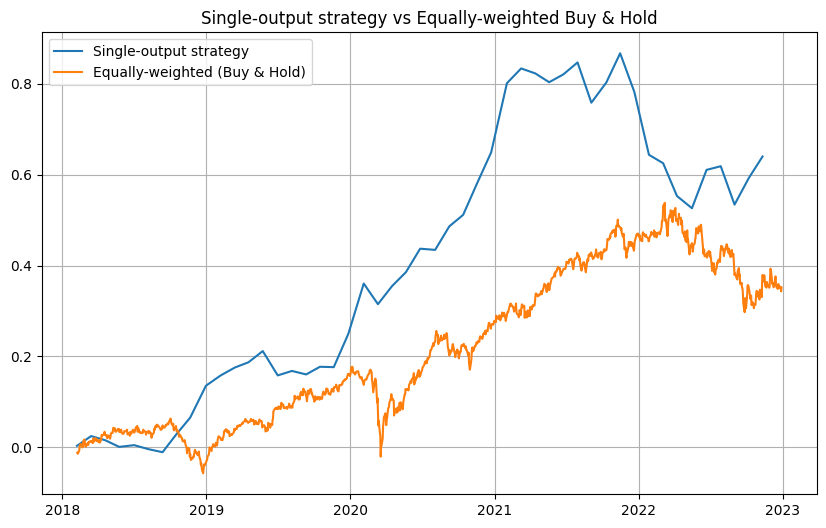

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Ensure datetime index
try:
    df.index = pd.to_datetime(df.index)
except Exception:
    df = df.copy()
    df.index = pd.to_datetime(df.index)

# Build per-ETF predictions DataFrame (single-output predictions)
preds_series = {}
# Priority: use existing 'full_predictions' dict if present, otherwise use trained_lstm_models to predict on concatenated scaled X.
if 'full_predictions' in globals() and isinstance(full_predictions, dict) and any(len(v) for v in full_predictions.values()):
    for etf in etfs:
        arr = np.array(full_predictions.get(etf, [])).ravel()
        # Try to get original indices created earlier; fallback to numeric index
        idx = original_indices_data.get(etf, None)
        if idx is not None and len(arr) == len(idx):
            idx_dt = pd.to_datetime(idx)
            preds_series[etf] = pd.Series(arr, index=idx_dt, name=etf)
        else:
            # If lengths don't match, try test indices from X_lstm_test shapes
            if etf in original_indices_data:
                idx_dt = pd.to_datetime(original_indices_data[etf])
                L = min(len(arr), len(idx_dt))
                if L > 0:
                    preds_series[etf] = pd.Series(arr[:L], index=idx_dt[:L], name=etf)
else:
    # Try to build predictions from in-memory trained models
    for etf in etfs:
        if etf in trained_lstm_models and etf in scalers_y:
            model = trained_lstm_models[etf]
            X_parts = []
            idx_parts = []
            if etf in original_indices_data:
                idx_parts = list(original_indices_data[etf])
            # We'll predict on the concatenated scaled arrays if available
            X_tr = X_lstm_training_scaled.get(etf, np.empty((0,sequence_length,1)))
            X_va = X_lstm_validation_scaled.get(etf, np.empty((0,sequence_length,1)))
            X_te = X_lstm_test_scaled.get(etf, np.empty((0,sequence_length,1)))
            if X_tr.size or X_va.size or X_te.size:
                X_full = np.concatenate([X_tr, X_va, X_te], axis=0) if (X_tr.size or X_va.size or X_te.size) else np.empty((0,sequence_length,1))
                if X_full.size:
                    pred_s = model.predict(X_full, verbose=0).ravel()
                    pred = scalers_y[etf].inverse_transform(pred_s.reshape(-1,1)).ravel()
                    # Assign index: if we have original_indices_data with same length, use it; else use numeric index
                    if etf in original_indices_data and len(pred) == len(original_indices_data[etf]):
                        preds_series[etf] = pd.Series(pred, index=pd.to_datetime(original_indices_data[etf]), name=etf)
                    else:
                        preds_series[etf] = pd.Series(pred, name=etf)
# Create DataFrame of single-output predictions aligned by date (drop rows where all predictions are missing)
preds_single_df = pd.DataFrame(preds_series).sort_index()
preds_single_df = preds_single_df.dropna(how='all')

# Backtest helper (non-overlapping windows)
def backtest_nonoverlap_from_preds(predictions_df, df_with_targets, etfs_list, horizon=25, top_k=2, bottom_k=2, allow_short=True):
    predictions_df = predictions_df.sort_index()
    if predictions_df.empty:
        return pd.Series(dtype=float), {}
    rebalance_dates = predictions_df.index[::horizon]
    returns_list = []
    dates = []
    for d in rebalance_dates:
        pos = df_with_targets.index.searchsorted(d)
        if pos >= len(df_with_targets.index):
            break
        use_date = df_with_targets.index[pos]
        if d not in predictions_df.index:
            continue
        preds = predictions_df.loc[d].dropna()
        if len(preds) < (top_k + bottom_k):
            continue
        ranked = preds.sort_values(ascending=False)
        longs = ranked.index[:top_k].tolist()
        shorts = ranked.index[-bottom_k:].tolist()
        realized = {}
        ok = True
        for a in longs + shorts:
            col = f"Target {a}"
            if col in df_with_targets.columns and not pd.isna(df_with_targets.loc[use_date, col]):
                realized[a] = df_with_targets.loc[use_date, col]
            else:
                ok = False
                break
        if not ok:
            continue
        long_ret = np.mean([realized[a] for a in longs])
        if allow_short:
            short_ret = np.mean([realized[a] for a in shorts])
            port_ret = 0.5 * long_ret - 0.5 * short_ret
        else:
            port_ret = long_ret
        returns_list.append(port_ret)
        dates.append(use_date)
    s = pd.Series(returns_list, index=dates).sort_index()
    if s.empty:
        return s, {}
    cumulative = (1 + s).prod() - 1
    total_days = len(s) * horizon
    ann_return = (1 + cumulative) ** (252.0 / total_days) - 1
    ann_vol = s.std() * np.sqrt(252.0 / horizon) if len(s) > 1 else 0.0
    sharpe = ann_return / ann_vol if ann_vol and not np.isnan(ann_vol) else np.nan
    metrics = {"n_windows": len(s), "cumulative_return": cumulative, "annualized_return": ann_return, "annualized_vol": ann_vol, "sharpe": sharpe}
    return s, metrics

# Backtest single-output strategy
single_port_series, single_metrics = backtest_nonoverlap_from_preds(preds_single_df, df, etfs, horizon=25, top_k=2, bottom_k=2, allow_short=True)
print("Single-output strategy metrics:", single_metrics)

# Equally-weighted buy-and-hold (for comparison)
if not preds_single_df.empty:
    test_start = preds_single_df.index[0]
else:
    test_start = df.index[int(len(df) * 0.66)]
prices_test = df.loc[test_start:, etfs].dropna()
if prices_test.shape[0] > 1:
    daily_returns_test = prices_test.pct_change().dropna()
    ew_daily = daily_returns_test.mean(axis=1)
    ew_cumulative = (1 + ew_daily).cumprod() - 1
    ew_total = ew_cumulative.iloc[-1]
    ew_ann_return = (1 + ew_total) ** (252.0 / len(daily_returns_test)) - 1
    ew_ann_vol = daily_returns_test.std(axis=0).mean() * np.sqrt(252.0)
    ew_sharpe = ew_ann_return / ew_ann_vol if ew_ann_vol else np.nan
else:
    ew_total = ew_ann_return = ew_ann_vol = ew_sharpe = np.nan
print("Equally-weighted buy-and-hold metrics:", {"total_return": ew_total, "annualized_return": ew_ann_return, "annualized_vol": ew_ann_vol, "sharpe": ew_sharpe})

# Plot single strategy vs EW
plt.figure(figsize=(10,6))
if isinstance(single_port_series, pd.Series) and not single_port_series.empty:
    cs_single = (1 + single_port_series).cumprod() - 1
    plt.plot(cs_single.index, cs_single.values, label='Single-output strategy')
if 'ew_cumulative' in locals():
    plt.plot(ew_cumulative.index, ew_cumulative.values, label='Equally-weighted (Buy & Hold)')
plt.title('Single-output strategy vs Equally-weighted Buy & Hold')
plt.legend(); plt.grid(True); plt.show()


# Step 3

Total sequences (all): (1233, 25, 5) indices: 1233
Sequences with full target available: 1208
Multi splits (train / val / test) sequence counts: 731 252 225


Model: "functional_321"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 25, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 25, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3486 - mae: 0.6536 - val_loss: 1.1561 - val_mae: 1.5881 - learning_rate: 0.0010
Epoch 2/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2854 - mae: 0.5790 - val_loss: 1.5857 - val_mae: 2.0291 - learning_rate: 0.0010
Epoch 3/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2637 - mae: 0.5510 - val_loss: 1.0731 - val_mae: 1.4946 - learning_rate: 0.0010
Epoch 4/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2372 - mae: 0.5170 - val_loss: 1.9936 - val_mae: 2.4306 - learning_rate: 0.0010
Epoch 5/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2070 - mae: 0.4797 - val_loss: 2.3169 - val_mae: 2.7660 - learning_rate: 0.0010
Epoch 6/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1656 - mae: 0.4172 - val_loss: 2.3447 - val_mae: 2.7924 - learning_rate: 0.0010
Epoch 7/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1453 - mae: 0.3846 - val_loss: 1.8966 - val_mae: 2.3409 - learning_rate: 5.0000e-04
Epoc

Model: "functional_322"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 25, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 25, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.3688 - mae: 0.6893 - val_loss: 0.5320 - val_mae: 0.8906 - learning_rate: 3.0000e-04
Epoch 2/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3168 - mae: 0.6197 - val_loss: 0.9359 - val_mae: 1.3499 - learning_rate: 3.0000e-04
Epoch 3/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2856 - mae: 0.5786 - val_loss: 1.1303 - val_mae: 1.5513 - learning_rate: 3.0000e-04
Epoch 4/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.2755 - mae: 0.5663 - val_loss: 1.2286 - val_mae: 1.6546 - learning_rate: 3.0000e-04
Epoch 5/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2526 - mae: 0.5380 - val_loss: 1.2114 - val_mae: 1.6337 - learning_rate: 1.5000e-04
Epoch 6/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.2397 - mae: 0.5184 - val_loss: 1.3191 - val_mae: 1.7423 - learning_rate: 1.5000e-04
Epoch 7/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2217 - mae: 0.4962 - val_loss: 1.2939 - val_mae: 1.7206 - learni

Model: "functional_323"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 25, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 25, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.3714 - mae: 0.6884 - val_loss: 0.3936 - val_mae: 0.7404 - learning_rate: 1.0000e-04
Epoch 2/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.3484 - mae: 0.6544 - val_loss: 0.4178 - val_mae: 0.7784 - learning_rate: 1.0000e-04
Epoch 3/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.3331 - mae: 0.6344 - val_loss: 0.4727 - val_mae: 0.8476 - learning_rate: 1.0000e-04
Epoch 4/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.3214 - mae: 0.6197 - val_loss: 0.5518 - val_mae: 0.9341 - learning_rate: 1.0000e-04
Epoch 5/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.3066 - mae: 0.6007 - val_loss: 0.6119 - val_mae: 1.0006 - learning_rate: 5.0000e-05
Epoch 6/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2959 - mae: 0.5865 - val_loss: 0.6908 - val_mae: 1.0859 - learning_rate: 5.0000e-05
Epoch 7/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.2851 - mae: 0.5734 - val_loss: 0.7710 - val_mae: 1.1737 - learni

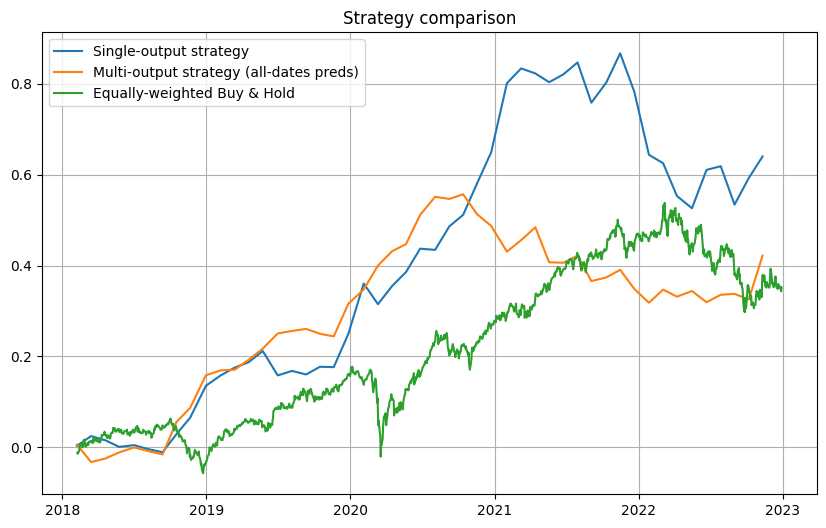

In [100]:

assets = etfs[:]
target_cols = [f"Target {a}" for a in assets]
targets_df_full = df[target_cols].copy()
targets_df_full.columns = assets
feat_df = df[assets].copy()

# align frames
common_idx = feat_df.index.intersection(targets_df_full.index)
feat_aligned = feat_df.loc[common_idx]
targets_aligned = targets_df_full.loc[common_idx]

# Build sequences for ALL possible sequence-ends (no requirement that Y exists)
X_all = []
Y_all = []
idx_all = []
target_available_flags = []

for i in range(len(feat_aligned) - sequence_length):
    seq_X = feat_aligned.iloc[i:i+sequence_length].values      # (lookback, n_assets)
    seq_Y = targets_aligned.iloc[i + sequence_length].values  # (n_assets,) may contain NaN
    seq_date = feat_aligned.index[i + sequence_length]
    X_all.append(seq_X)
    Y_all.append(seq_Y)
    idx_all.append(seq_date)
    # Flag whether this sequence-end has a full target vector (no NaNs)
    target_available_flags.append(not np.any(pd.isna(seq_Y)))

X_all = np.array(X_all)            # shape (N_all, lookback, n_assets)
Y_all = np.array(Y_all)            # shape (N_all, n_assets)
idx_all = pd.Index(idx_all)
target_available_flags = np.array(target_available_flags, dtype=bool)

print("Total sequences (all):", X_all.shape, "indices:", len(idx_all))
print("Sequences with full target available:", target_available_flags.sum())

# Now create the subset used for training/val/test (only those with targets)
X_with_target = X_all[target_available_flags]
Y_with_target = Y_all[target_available_flags]
idx_with_target = idx_all[target_available_flags]

# create date splits based on idx_with_target (these are sequence-end dates)
train_end = pd.to_datetime("2020-12-31")
val_end   = pd.to_datetime("2021-12-31")

mask_tr = idx_with_target <= train_end
mask_va = (idx_with_target > train_end) & (idx_with_target <= val_end)
mask_te = idx_with_target > val_end

X_tr = X_with_target[mask_tr]
Y_tr = Y_with_target[mask_tr]
X_va = X_with_target[mask_va]
Y_va = Y_with_target[mask_va]
X_te = X_with_target[mask_te]
Y_te = Y_with_target[mask_te]
idx_te_multi = idx_with_target[mask_te]

print("Multi splits (train / val / test) sequence counts:", X_tr.shape[0], X_va.shape[0], X_te.shape[0])

n_assets = len(assets)

# Scale features (fit on train only) and also transform X_all for full-date predictions
scaler_X_multi = StandardScaler()
if X_tr.size:
    Xtr2 = X_tr.reshape(X_tr.shape[0], -1)  # (Ntr, lookback*n_assets)
    scaler_X_multi.fit(Xtr2)
    X_tr_s = scaler_X_multi.transform(Xtr2).reshape(X_tr.shape)
    # validation/test scaled (if present)
    X_va_s = scaler_X_multi.transform(X_va.reshape(X_va.shape[0], -1)).reshape(X_va.shape) if X_va.size else np.empty((0, sequence_length, n_assets))
    X_te_s = scaler_X_multi.transform(X_te.reshape(X_te.shape[0], -1)).reshape(X_te.shape) if X_te.size else np.empty((0, sequence_length, n_assets))
    # scale the full set (all dates)
    X_all_s = scaler_X_multi.transform(X_all.reshape(X_all.shape[0], -1)).reshape(X_all.shape)
else:
    # no train data -> cannot scale/train
    X_tr_s = np.empty((0, sequence_length, n_assets)); X_va_s = np.empty((0, sequence_length, n_assets)); X_te_s = np.empty((0, sequence_length, n_assets))
    X_all_s = np.empty((0, sequence_length, n_assets))

# Scale Y (fit on train only)
scaler_Y_multi = StandardScaler()
if Y_tr.size:
    scaler_Y_multi.fit(Y_tr)
    Y_tr_s = scaler_Y_multi.transform(Y_tr)
    Y_va_s = scaler_Y_multi.transform(Y_va) if Y_va.size else np.empty((0, n_assets))
    Y_te_s = scaler_Y_multi.transform(Y_te) if Y_te.size else np.empty((0, n_assets))
else:
    Y_tr_s = np.empty((0, n_assets)); Y_va_s = np.empty((0, n_assets)); Y_te_s = np.empty((0, n_assets))

# If no training samples available, skip training
if X_tr_s.size == 0 or Y_tr_s.size == 0:
    print("Not enough training data for multi-output model; skipping multi-output training.")
    multi_preds_all_df = pd.DataFrame(index=idx_all, columns=assets)  # empty
    multi_preds_df = pd.DataFrame()  # empty test-only DF
    multi_metrics_per_asset = {}
    multi_port_series = pd.Series(dtype=float)
    multi_metrics = {}
else:
    # build the improved multi-output model (same architecture as before)
    from tensorflow.keras import regularizers
    def build_multi_model(input_shape, n_outputs, l2=1e-4):
        inp = Input(shape=input_shape)
        x = LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(l2))(inp)
        x = Dropout(0.2)(x)
        x = LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(l2))(x)
        x = Dropout(0.15)(x)
        x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
        x = Dropout(0.1)(x)
        out = Dense(n_outputs, activation='linear')(x)
        m = Model(inp, out)
        print(m.summary())
        return m

    # small learning-rate scan (select best lr using val loss)
    candidate_lrs = [1e-3, 3e-4, 1e-4]
    best_val = np.inf
    best_model = None
    best_hist = None
    best_lr = None

    for lr in candidate_lrs:
        tf.random.set_seed(SEED)
        model_multi = build_multi_model((sequence_length, n_assets), n_assets)
        model_multi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.Huber(), metrics=['mae'])
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
        rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
        hist = model_multi.fit(
            X_tr_s, Y_tr_s,
            validation_data=(X_va_s, Y_va_s) if X_va_s.size else None,
            epochs=80, batch_size=16,
            callbacks=[es, rl],
            verbose=1
        )
        val_loss = min(hist.history.get('val_loss', [np.inf]))
        if val_loss < best_val:
            best_val = val_loss
            best_model = model_multi
            best_hist = hist
            best_lr = lr

    print("Trained multi-output model | best lr:", best_lr, "best val_loss:", best_val)

    # ---- Predictions for ALL dates (every sequence end) ----
    # Use best_model and X_all_s (which includes sequences where target may be missing)
    preds_all_scaled = best_model.predict(X_all_s, verbose=0)
    preds_all = scaler_Y_multi.inverse_transform(preds_all_scaled)  # shape (N_all, n_assets)
    multi_preds_all_df = pd.DataFrame(preds_all, index=idx_all, columns=assets).sort_index()

    # ---- Predictions on test subset (for metrics & comparison) ----
    if X_te_s.size and Y_te.size:
        preds_te_scaled = best_model.predict(X_te_s, verbose=0)
        preds_te = scaler_Y_multi.inverse_transform(preds_te_scaled)
        multi_preds_df = pd.DataFrame(preds_te, index=idx_te_multi, columns=assets).sort_index()
        # per-asset metrics on test
        multi_metrics_per_asset = {}
        for i, a in enumerate(assets):
            y_true = Y_te[:, i]
            y_pred = preds_te[:, i]
            mse = ((y_true - y_pred)**2).mean()
            mae = np.mean(np.abs(y_true - y_pred))
            diracc = np.mean(np.sign(y_pred) == np.sign(y_true))
            multi_metrics_per_asset[a] = {'MSE': mse, 'MAE': mae, 'DirAcc': diracc}
        print("Multi-output test metrics per asset:")
        print(pd.DataFrame(multi_metrics_per_asset).T)
    else:
        multi_preds_df = pd.DataFrame()
        multi_metrics_per_asset = {}
        print("No multi-output test set available (or empty).")

    multi_port_series, multi_metrics = backtest_nonoverlap_from_preds(multi_preds_all_df, df, assets, horizon=25, top_k=2, bottom_k=2, allow_short=True)
    print("Multi-output strategy metrics (using all-date predictions):", multi_metrics)

    # Plot cumulative returns comparison
    plt.figure(figsize=(10,6))
    if isinstance(single_port_series, pd.Series) and not single_port_series.empty:
        plt.plot((1 + single_port_series).cumprod().index, (1 + single_port_series).cumprod().values - 1, label='Single-output strategy')
    if isinstance(multi_port_series, pd.Series) and not multi_port_series.empty:
        plt.plot((1 + multi_port_series).cumprod().index, (1 + multi_port_series).cumprod().values - 1, label='Multi-output strategy (all-dates preds)')
    if 'ew_cumulative' in locals():
        plt.plot(ew_cumulative.index, ew_cumulative.values, label='Equally-weighted Buy & Hold')
    plt.legend(); plt.title('Strategy comparison'); plt.grid(True); plt.show()
